In [1]:
import re
import time
import math
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing 
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# Predicting Credit Card Fraud

It is important for credit card companies to be able to detect credit card fraud. It makes it possible for the company to recgonize fraud even before the cutomer so that measures can be taken to stop futher charges from happening and so that the customer isn't charged for items they didn't purchase.

To examin how this can be accomplished a data set taken from Kaggle.com will be used. It consists of 284,807 transactions and 31 features from September 2013 of european cardholders.

In [2]:
# Load data
credit_fraud = pd.read_csv('C:/Users/keith/Desktop/Thinkful/creditcard.csv',encoding = "ISO-8859-1")

pd.set_option('display.max_columns', None) # disables trucated columns 
pd.set_option('display.max_rows', None) # disables trucated rows


In [84]:
credit_fraud.shape # get the number of columns and rows

(284807, 31)

In [85]:
credit_fraud.head() # take a peek at the data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The data frame contains features that are the components from the results of a priciple components analysis. There is no other information given about features V1 through V28. The remaining untransformed features are the amount of the transaction, the amount of time between each transaction and the first transaction in the dataset, "Amount" and "Time", respectively. The "Class" feature labels each observation with a "1" for fraud and a "0" for a valid transaction. 

## Data Cleaning

In [86]:
credit_fraud.isnull().sum().sum() # check for null values 

0

In [87]:
credit_fraud.dtypes # take a look at the data types

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [88]:
 credit_fraud.duplicated().sum()

1081

There really isn't much cleaning to do as far as can be seen for now. There are some duplicate rows but since there isn't much background information on the data we don't know if they are true duplicates or not so they will remain included in the modeling. 

## Exploratory data analysis

In [89]:
credit_fraud.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

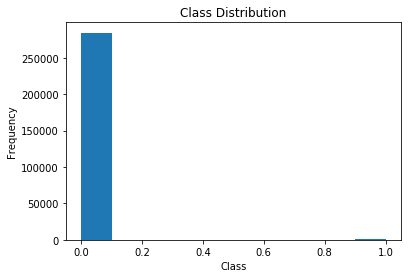

0    284315
1       492
Name: Class, dtype: int64

In [90]:
credit_fraud.Class.plot(kind="hist")
plt.title('Class Distribution')
plt.xlabel('Class')
plt.show()
credit_fraud.Class.value_counts()

In [91]:
len(credit_fraud[credit_fraud['Class']==1].Class)/len(credit_fraud[credit_fraud['Class']==0].Class)

0.0017304750013189597

This is a very unbalaced dataset. The fraudlent class, which is the class of interest here, is only .17% of the data. 

In [92]:
# Descriptive Statistics

credit_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


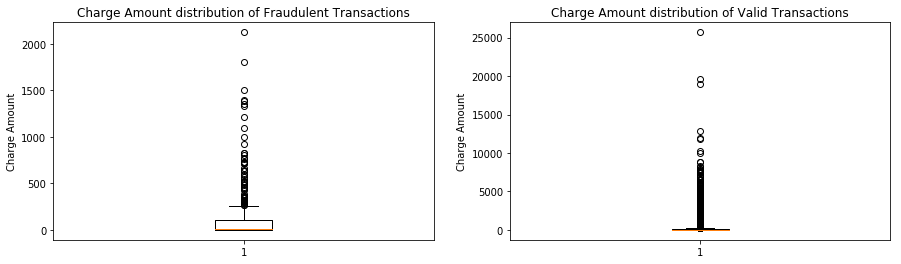

In [93]:
time_fraud = credit_fraud[credit_fraud.Class==1].Amount
time_valid = credit_fraud[credit_fraud.Class==0].Amount

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.boxplot(time_fraud)
plt.ylabel('Charge Amount')
plt.title('Charge Amount distribution of Fraudulent Transactions')

plt.subplot(1, 2, 2)
plt.boxplot(time_valid)
plt.ylabel('Charge Amount')
plt.title('Charge Amount distribution of Valid Transactions')
plt.show()

There are some major outliers that may have a negative affect when a statistical model such as logistic regression is used.

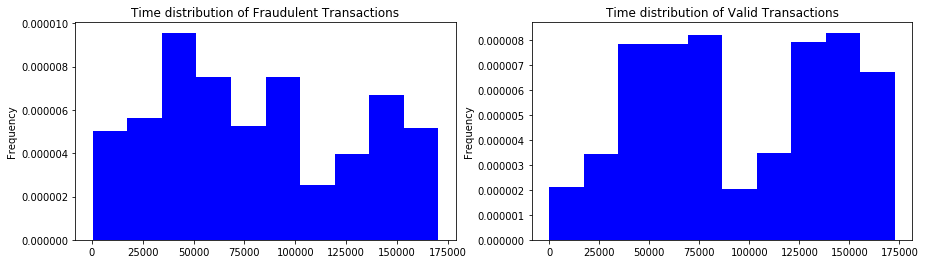

In [94]:
time_fraud = credit_fraud[credit_fraud.Class==1].Time
time_valid = credit_fraud[credit_fraud.Class==0].Time

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(time_fraud, color='blue',density=True)
plt.ylabel('Frequency')
plt.title('Time distribution of Fraudulent Transactions')

plt.subplot(1, 2, 2)
plt.hist(time_valid, color='blue',density=True)
plt.ylabel('Frequency')
plt.title('Time distribution of Valid Transactions')
plt.show()

The other featured that we have a little information on it the time. Unfortunately there doesnt seem to be a significant difference in the distrubutions between the times of valid charges and fraudulent charges.

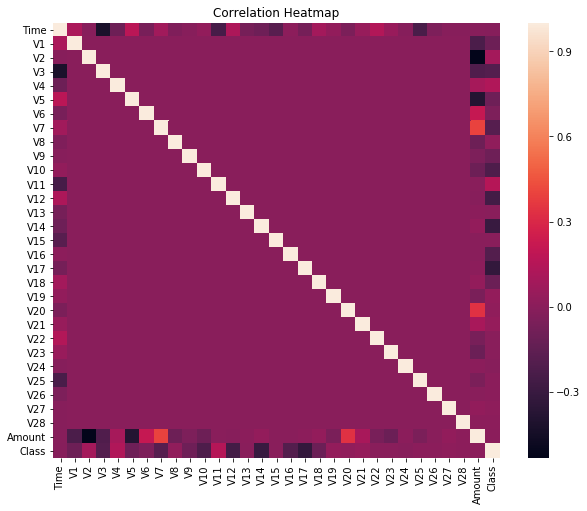

In [95]:
plt.figure(figsize=(10,8))
sns.heatmap(credit_fraud.corr())
plt.title('Correlation Heatmap')

plt.show()

From the correlation heatmap, as expected, since features V1-V28 were results from PCA they show virtually zero correlation with each other. 

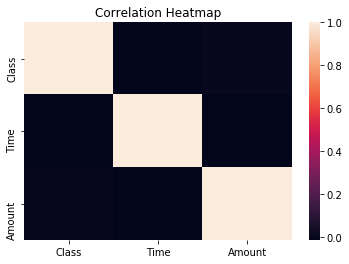

In [96]:
sns.heatmap(credit_fraud[['Class','Time','Amount']].corr())
plt.title('Correlation Heatmap')
plt.show()

Taking a closer look at just the features that we have background on it doesn't appear that they correlate very much if at all with our target variable.

# Naive Bayes

In [3]:
# Create training and testing sets
from sklearn.model_selection import train_test_split 
X = credit_fraud.drop(['Class','Time'],1)
Y = credit_fraud.Class

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=20)


In [155]:
# Instatiate the model

from sklearn.naive_bayes import BernoulliNB 
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
print(bnb.score(X_test, y_test))
from sklearn.model_selection import cross_val_score

print(cross_val_score(bnb, X_test, y_test, cv=5))

0.9992556388865481
[0.99936802 0.9992978  0.9989467  0.99929775 0.99922747]


In [156]:
y_pred = bnb.predict(X_test)

# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report

target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Consfusion Matrix
Class      0   1
row_0           
0      71076  36
1         17  73

Classification Report
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00     71093
       fraud       0.81      0.67      0.73       109

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.91      0.83      0.87     71202
weighted avg       1.00      1.00      1.00     71202



In [157]:
# Create balanced classes for the training set

import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X_train, y_train = ros.fit_sample(X_train, y_train)

In [158]:
from sklearn.naive_bayes import BernoulliNB

 
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
print(bnb.score(X_test, y_test))
from sklearn.model_selection import cross_val_score

print(cross_val_score(bnb, X_test, y_test, cv=5))
print(cross_val_score(bnb, X, Y, cv=5))

0.9916434931603045
[0.99936802 0.9992978  0.9989467  0.99929775 0.99922747]
[0.99877111 0.99949089 0.9989642  0.99917487 0.99919243]


In [159]:
# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()
# Classification report
print("Classification Report")
from sklearn.metrics import classification_report
y_pred = bnb.predict(X_test)
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Consfusion Matrix
Class      0   1
row_0           
0      70515  17
1        578  92

Classification Report
              precision    recall  f1-score   support

       valid       1.00      0.99      1.00     71093
       fraud       0.14      0.84      0.24       109

   micro avg       0.99      0.99      0.99     71202
   macro avg       0.57      0.92      0.62     71202
weighted avg       1.00      0.99      0.99     71202



It seems like the unbalanced set scored better that the balanced training set that was created

# KNN

In [97]:
# Create training and testing sets
from sklearn.model_selection import train_test_split 
X = credit_fraud.drop(['Class','Time'],1)
Y = credit_fraud.Class

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=20)


In [171]:
pd.Series(y_train).value_counts()

0    213222
1       383
Name: Class, dtype: int64

In [172]:
# intantiate the model
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=1,weights='distance',p=1) 
neighbors.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=1,
           weights='distance')

In [173]:
y_pred = neighbors.predict(X_test)

# Confusion matrix

print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Consfusion Matrix
Class      0   1
row_0           
0      71078  29
1         15  80

Classification Report
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00     71093
       fraud       0.84      0.73      0.78       109

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.92      0.87      0.89     71202
weighted avg       1.00      1.00      1.00     71202



In [174]:
# Create balanced classes for the training set

import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X_train, y_train = ros.fit_sample(X_train, y_train)

In [175]:
pd.Series(y_train).value_counts()

1    213222
0    213222
dtype: int64

In [176]:
# intantiate the model
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=1,weights='distance',p=1) 
neighbors.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=1,
           weights='distance')

In [177]:
y_pred = neighbors.predict(X_test)

# Confusion matrix

print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Consfusion Matrix
Class      0   1
row_0           
0      71078  29
1         15  80

Classification Report
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00     71093
       fraud       0.84      0.73      0.78       109

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.92      0.87      0.89     71202
weighted avg       1.00      1.00      1.00     71202



Both the unbalanced set and the balaced set the same. From here GridsearchCV will be used to tune the hyperparameters on the unbalanced set since it is most similar to the original data.

In [ ]:
# recreate the unbalanced training/test set
from sklearn.model_selection import train_test_split 
X = credit_fraud.drop(['Class','Time'],1)
Y = credit_fraud.Class
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=20)

# initiate GridsearchCV
from sklearn.model_selection import GridSearchCV
param_grid = dict(weights=['distance','uniform'],n_neighbors=range(1,10,1))
grid = GridSearchCV(neighbors, param_grid, cv=5, scoring="f1", return_train_score=True)
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
neighbors = KNeighborsClassifier(n_neighbors=1, weights='distance') 
neighbors.fit(X_train, y_train) 

In [ ]:
y_pred = neighbors.predict(X_test)

# Confusion matrix

print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

# Decision Trees

In [179]:
from sklearn import tree

# Initialize and train decision tree.
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_features= 'sqrt',
                                            max_depth=8, random_state=20,)

decision_tree.fit(X_train, y_train)
print(cross_val_score(decision_tree, X_test, y_test, cv=10))

[0.99957871 0.99915742 0.99943828 0.99929775 0.9988764  0.9988764
 0.99929775 0.99929775 0.99957865 0.99915718]


In [180]:
y_pred = decision_tree.predict(X_test)

# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report 
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Consfusion Matrix
Class      0   1
row_0           
0      71084  23
1          9  86

Classification Report
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00     71093
       fraud       0.91      0.79      0.84       109

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.95      0.89      0.92     71202
weighted avg       1.00      1.00      1.00     71202



In [181]:
# Create balanced classes for the training set

import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X_train, y_train = ros.fit_sample(X_train, y_train)

In [182]:
# Initialize and train decision tree.
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_features= 'sqrt',
                                            max_depth=8, random_state=20,)

decision_tree.fit(X_train, y_train)
print(cross_val_score(decision_tree, X_test, y_test, cv=10))

[0.99957871 0.99915742 0.99943828 0.99929775 0.9988764  0.9988764
 0.99929775 0.99929775 0.99957865 0.99915718]


In [183]:
y_pred = decision_tree.predict(X_test)

# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report 
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Consfusion Matrix
Class      0   1
row_0           
0      70292  19
1        801  90

Classification Report
              precision    recall  f1-score   support

       valid       1.00      0.99      0.99     71093
       fraud       0.10      0.83      0.18       109

   micro avg       0.99      0.99      0.99     71202
   macro avg       0.55      0.91      0.59     71202
weighted avg       1.00      0.99      0.99     71202



In [ ]:
# recreate the unbalanced training/test set
from sklearn.model_selection import train_test_split 
X = credit_fraud.drop(['Class','Time'],1)
Y = credit_fraud.Class
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=20)

# initiate GridsearchCV
from sklearn.model_selection import GridSearchCV
param_grid = dict(weights=['distance','uniform'],n_neighbors=range(1,10,1))
grid = GridSearchCV(neighbors, param_grid, cv=5, scoring="f1", return_train_score=True)
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_features= 'sqrt', max_leaf_nodes=9,
                                            max_depth=3, random_state=20,)

decision_tree.fit(X_train, y_train)
print(cross_val_score(decision_tree, X_test, y_test, cv=10))

In [ ]:
y_pred = decision_tree.predict(X_test)

# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report 
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

# Random forrest

In [74]:
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier(criterion='entropy',random_state=20, max_features='sqrt') 
rfc.fit(X_train,y_train)

print(cross_val_score(rfc, X_test, y_test, cv=5))

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.9996489  0.99922758 0.99901692 0.99950843 0.99971908]


In [75]:
y_pred = rfc.predict(X_test)

# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report 
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Consfusion Matrix
Class      0   1
row_0           
0      71088  24
1          5  85

Classification Report
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00     71093
       fraud       0.94      0.78      0.85       109

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.97      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [76]:
# Create balanced classes for the training set

import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X_train, y_train = ros.fit_sample(X_train, y_train)

In [77]:
rfc = ensemble.RandomForestClassifier(criterion='entropy',random_state=20, max_features='sqrt') 
rfc.fit(X_train,y_train)

print(cross_val_score(rfc, X_test, y_test, cv=5))

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.9996489  0.99922758 0.99901692 0.99950843 0.99971908]


In [78]:
y_pred = rfc.predict(X_test)

# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report 
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Consfusion Matrix
Class      0   1
row_0           
0      71087  22
1          6  87

Classification Report
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00     71093
       fraud       0.94      0.80      0.86       109

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.97      0.90      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [28]:
param_grid = dict(max_depth=range(1,5),max_leaf_nodes=range(6,20),max_features=['sqrt',4])
grid = GridSearchCV(rfc, param_grid, cv=5, scoring="f1", return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=20, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 5), 'max_leaf_nodes': range(6, 20), 'max_features': ['sqrt', 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [29]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 19}
0.8208092654415923


In [94]:
rfc = ensemble.RandomForestClassifier(criterion='entropy',random_state=20, max_depth=4,
                                      max_leaf_nodes=19 ,max_features='sqrt') 
rfc.fit(X_train,y_train)

print(cross_val_score(rfc, X_test, y_test, cv=5))

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.9996489  0.99936802 0.99915736 0.99957865 0.99971908]


In [95]:
y_pred = rfc.predict(X_test)

# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report 
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Class      0   1
row_0           
0      70801  15
1        292  94


# Logistic regression

In [4]:
# Create balanced classes for the training set

import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X_train, y_train = ros.fit_sample(X_train, y_train)

In [99]:
pd.Series(y_train).value_counts()

1    213222
0    213222
dtype: int64

In [100]:
# Declare a logistic regression classifier.
 


lr = LogisticRegression(random_state=20, fit_intercept=False ,solver='liblinear',max_iter=100) 
 
# Fit the model.
fit = lr.fit(X_train, y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X_test)

print('\n Accuracy by Motor vehicle theft')
print(pd.crosstab(pred_y_sklearn, y_test))

print('\n Percentage accuracy')
print(lr.score(X_test, y_test))

Coefficients
[[-0.7779652  -2.79907164 -1.02454306  1.22673213 -1.63969957  0.91918655
   2.24764725 -1.1986964  -0.43542854 -1.14921141  0.53454754 -0.93954114
  -0.09858489 -0.93932494  0.1365059  -0.36441635 -0.71500631 -0.01058099
  -0.37002515  2.12328751  0.76746885 -0.55202079 -2.46105735  0.04431638
  -0.84641037 -0.29754712  1.16253206  1.36460603 -0.02525076]]
0.0

 Accuracy by Motor vehicle theft
Class      0    1
row_0            
0      68099    8
1       2994  101

 Percentage accuracy
0.9578382629701413


In [101]:
y_pred = lr.predict(X_test)
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

              precision    recall  f1-score   support

       valid       1.00      0.96      0.98     71093
       fraud       0.03      0.93      0.06       109

   micro avg       0.96      0.96      0.96     71202
   macro avg       0.52      0.94      0.52     71202
weighted avg       1.00      0.96      0.98     71202



# Logistic Ridge regression

In [8]:
log_Rr = LogisticRegression(penalty='l2',fit_intercept=False, solver='lbfgs', max_iter=100000, 
                            random_state=20,class_weight='balanced', C=10000)
fit = log_Rr.fit(X_train, y_train)


# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y = log_Rr.predict(X_test)

print('\n Accuracy by credit card fraud')
print(pd.crosstab(pred_y, y_test))

print('\n Percentage accuracy')
print(log_Rr.score(X_test, y_test))

Coefficients
[[-0.77857231 -2.80288085 -1.02527454  1.22805418 -1.64146014  0.9207687
   2.25155805 -1.20137401 -0.43550234 -1.14993981  0.53689239 -0.94289301
  -0.09918831 -0.94306263  0.13654573 -0.3662456  -0.71962599 -0.01274879
  -0.3704462   2.12989703  0.76951025 -0.55316663 -2.46433178  0.04469705
  -0.84478621 -0.29889576  1.17489075  1.37542069 -0.02528705]]
[0.]

 Accuracy by credit card fraud
Class      0    1
row_0            
0      68099    8
1       2994  101

 Percentage accuracy
0.9578382629701413


In [9]:
from sklearn.metrics import classification_report
y_pred = log_Rr.predict(X_test)
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

              precision    recall  f1-score   support

       valid       1.00      0.96      0.98     71093
       fraud       0.03      0.93      0.06       109

   micro avg       0.96      0.96      0.96     71202
   macro avg       0.52      0.94      0.52     71202
weighted avg       1.00      0.96      0.98     71202



# Logistic Lasso regression

In [10]:
logr_lasso = LogisticRegression(penalty='l1',solver='liblinear', fit_intercept=False,
                                random_state=20,max_iter=10000,class_weight='balanced', C=14)
fit = logr_lasso.fit(X_train, y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y = logr_lasso.predict(X_test)

print('\n Accuracy by Motor vehicle theft')
print(pd.crosstab(pred_y, y_test))

print('\n Percentage accuracy')
print(logr_lasso.score(X, Y))

Coefficients
[[-0.77767273 -2.80170911 -1.02491222  1.22761468 -1.64051374  0.91988226
   2.24993218 -1.20043237 -0.43584074 -1.15027229  0.53588208 -0.94166888
  -0.09859152 -0.9418573   0.13666082 -0.3663572  -0.71797948 -0.01164216
  -0.3702535   2.12579897  0.76804098 -0.55242459 -2.46291316  0.0442796
  -0.84733251 -0.29712951  1.16847672  1.36830323 -0.02527026]]
0.0

 Accuracy by Motor vehicle theft
Class      0    1
row_0            
0      68100    8
1       2993  101

 Percentage accuracy
0.9578135368863827


In [11]:
y_pred = log_Rr.predict(X_test)
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

              precision    recall  f1-score   support

       valid       1.00      0.96      0.98     71093
       fraud       0.03      0.93      0.06       109

   micro avg       0.96      0.96      0.96     71202
   macro avg       0.52      0.94      0.52     71202
weighted avg       1.00      0.96      0.98     71202



# gradient boost

In [79]:
from sklearn import ensemble 

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(n_estimators=500,max_depth=2,
                                          loss='deviance', random_state=20) 
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=20,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [80]:
y_pred = clf.predict(X_test)

# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report 
target_names = ['valid','fraud']
print(classification_report(y_test ,y_pred, target_names=target_names))

Consfusion Matrix
Class      0   1
row_0           
0      70896  15
1        197  94

Classification Report
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00     71093
       fraud       0.32      0.86      0.47       109

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.66      0.93      0.73     71202
weighted avg       1.00      1.00      1.00     71202



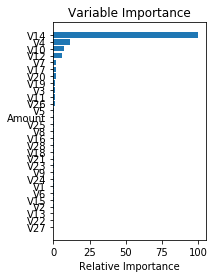

In [81]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Summary 

Before we can say which model was the most successful we need to be clear about how the models were graded. Since the class was so unbalance it would be east to get a very high accuracy score but the model still woudln't be good at detecting credit card fraud. The best way to judge each model is to look at the precision, recall and F-score from the classification report. The model that perfomrmed the best using this criteria was the Random Forrest model using a resampled data set to balance the classes. This produced a precision score of 0.94, a recall of 0.80 and an f1-score 0.86. This means that 80% of fraudulent transactions can be detected and of those 94% are actually fraud. While this score seem good there are still some transaction that can be labeld as fraudulent causing inconvience for the customer.

The models that did the worst were the regression models. Again, this was expected because of the assumption that are made for statistical models and how the data set we were working with deviated from those assumptions.

In the future more time could be spent tuning parameters, adjusting the data to minimize the affect of outliers for the statistical models, or do some digging to see if more information could be obtained about the duplicated data. We could also, look to see if there are any differences in data collected in other countries around the world to see if fraudulent credit card use patterns vary. We could then possible create a model that works internationally. 